In [1]:
%reset -f
# Réinitialise l'espace de noms en supprimant les noms définis par l'utilisateur
# -f sans demander de confirmation

import pandas as pd
# Bibliothèque de manipulation et d'analyse de données
pd.set_option('display.max_rows', 200)
# Option d'affichage des lignes à un maximum de 200
pd.set_option('display.max_columns', 200)
# Option d'affichage des colonnes à un maximum de 200
pd.options.mode.use_inf_as_na = True
# Reconnaître inf comme NaN dans les calculs

from matplotlib import pyplot as plt
# Bibliothèque destinée à tracer et visualiser des données sous forme de graphiques
plt.style.use('dark_background')
# Option de définition de la couleur de l'arrière plan 

In [2]:
from dask import dataframe as dd
# Bibliothèque de traitement en parallèle de données volumineuses
# ne tenant pas en mémoire

# Le gain en performance sur des datasets 
# de plusieurs giga est conséquent par rapport à pandas, numpy

dataset = dd.read_csv(
    "./DrDoS_LDAP.csv", 
    dtype={'SimillarHTTP': 'object'},
    blocksize='64MB')
# Enregistrer les données du fichier dans la variable dataset à l'aide de dask

dataset = dataset.compute()
# Conversion d'un dataframe dask en un dataframe pandas

In [3]:
dataset.columns = dataset.columns.str.replace(' ', '')
# Retirer les espaces dans le dataset

In [4]:
dataset.shape
# Donne la forme du dataframe :
# un tuple de dimensions indiquant le nombre de lignes : 2 181 542
# et le nombre de colonnes : 88

(2181542, 88)

In [5]:
(dataset['Label'].value_counts()) / len(dataset) * 100
# Présence de chaque label en % dans le dataset

DrDoS_LDAP    99.926107
BENIGN         0.073893
Name: Label, dtype: float64

In [6]:
dataset.drop(columns=['FlowID', 'SourceIP', 'DestinationIP', 'Timestamp', 'SimillarHTTP', 'SourcePort', 'DestinationPort'], inplace=True)
# Modification du dataset en enlevant les colonnes :
# FlowID, SourceIP, DestinationIP, Timestamp, SimillarHTTP, SourcePort, DestinationPort

In [7]:
dataset.dropna(inplace = True)
# Supprime les valeurs manquantes dans le dataset

In [8]:
cols = dataset.drop(columns=['Label']).columns.tolist()
# Supprimer la colonne label, retourne une liste de valeurs
for col in cols:
    dataset[col] = pd.to_numeric(dataset[col], errors = 'coerce').fillna(0)
    
# Conversion de l'ensemble des colonnes en format numérique 
# si elle n'est pas convertible est devient NaN ('coerce')
# Les valeurs NaN deviennent 0 (fillna(0))



In [9]:
labels = pd.get_dummies(dataset['Label'])
# Conversion de données catégorielles en variables indicatrices


In [10]:
X = dataset.drop(columns = ["Label"], axis = 1)
# Enregistre dans X le dataset sans la colonne Label 
#(axis=1 : l'axe verticale )
y = labels.BENIGN
# Enregistre dans y les valeurs de la colonne BENIGN

In [11]:
from sklearn.model_selection import train_test_split
# Divisez des tableaux ou des matrices en sous-ensembles d'entraînement et de test aléatoires

# X_... : les lignes du dataset
# y_... : les labels

# X_train_val : données d'entraînement servant à ajuster le modèle 
# associées aux données de validation

# X_test, y_test : données de test pour fournir une évaluation 
# impartiale d'un modèle

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, 
    y, 
    test_size = .2, 
    stratify = y, 
    random_state = 1)

# test_size : proportion de l'ensemble de données à inclure dans la répartition de test
# stratify : les données sont divisées de manière stratifiée
# random_state : contrôle le brassage appliqué aux données avant d'appliquer le fractionnement

In [12]:
# X_train, y_train : ensemble des données d'entraînement nécessaires
# à la formation du modèle

# X_val, y_val : ensemble des données utilisé pour fournir 
# une évaluation impartiale d'un modèle lors de l'entraînement

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, 
    y_train_val, 
    test_size = .25, 
    stratify = y_train_val, 
    random_state = 1)

In [13]:
from sklearn.preprocessing import StandardScaler
# Standardisez les caractéristiques en supprimant la moyenne 
# et en mettant à l'échelle la variance unitaire

std = StandardScaler()

In [14]:
# Standardisation des données d'entraînement :

X_train_scaled = pd.DataFrame(
    std.fit_transform(X_train),
    columns = X_train.columns)

# fit_transform : ajuster aux données, puis les transformer

In [15]:
import joblib
# Source : https://ml.dask.org/joblib.html
# Joblib fournit un pipelining léger pour Python 
# en améliorant le calcul en parallèle

from dask.distributed import Client
# Client permet de se connecter à un cluster Dask
client = Client(processes = False)
# Création d'un objet client servant de planificateur Dask par défaut
# Processes == false : le code dask s'exécutera en multithread 
# et non en multitraitement
# Sous Python le multithread n'est pas recommandé à cause du GIL 
# sauf si la majorité du travail est lié à des E/S

### Logistic Regression

In [16]:
# Un modèle de regression logistique permet d'étudier les relations 
# entre un ensemble de variables X et y. 
# Dans ce cas de figure, la régression logistique est utilisé 
# en guise de modèle de prédiction à l'aide d'une optimisation 
# de coefficients de régression lors de l'entraînement.
# La régression linéaire prédit les probabilités qu'un objet appartenant à chaque classe

from sklearn.linear_model import LogisticRegression
# Charger la classe implémentant la régression logistique
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

lr = LogisticRegression(solver = 'lbfgs', 
                        max_iter = 1000000, 
                        n_jobs = -1)
# solver : choix de l'algorithme d'optimisation, ici lbfgs
# max_iter : nombre d'itérations pour que les solveurs convergent
# n_jobs= : Nombre de processeur utilisés lors de la parallélisation
#           -1 signifie utiliser tous les processeurs

In [17]:
# De nombreux algorithmes Scikit-Learn sont écrits pour une exécution 
# en parallèle à l'aide de joblib fournissant un parallélisme basé 
# sur les threads et sur les processus.
# Dask pour faire évoluer ces algorithmes soutenus par joblib 
# vers un cluster de mahcine en fournissant un backend Joblib alternatif

with joblib.parallel_backend("dask"):
    lr.fit(X_train_scaled, y_train)
# fit : formation du modèle à l'aide des données d'entraînement standardisés X_train et de y_train

In [18]:
# Standardisation des données de validation :

X_val_scaled = pd.DataFrame(
    std.transform(X_val), 
    columns = X_val.columns)
# std.transform : transforme les données de validation et les standardisent

In [19]:
# Étape de prédiction :

y_val_preds = lr.predict(
    X_val_scaled)
# y_val_preds : les labels prédits 
# lr.predict : Prédiction du modèle à l'aide des données de validation à partir de X_train_scaled
# X_train_scaled : les lignes du dataset normisés


from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score

print("Precision: {}, Recall: {}, F2 Score: {}".format(
    precision_score(y_val, y_val_preds), 
    recall_score(y_val, y_val_preds), 
    fbeta_score(y_val, y_val_preds, beta=2.0)))

# Source : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html

# Précision_score : est le rapport entre le nombre de vrais positifs 
# et le nombre de faux positifs. La précision est intuitivement la capacité
# du classifieur à ne pas étiqueter un échantillon négatif comme positif

# recall_score : est le rapport entre le nombre de vrais positifs 
# et le nombre de faux négatifs. Le rappel est intuitivement 
# la capacité du classificateur à retrouver les échantillons positifs

# fbeta_score : est la moyenne harmonique pondérée de la précision 
# et du rappel, où f_beta atteint sa meilleure valeur à 1 et le pire à 0

Precision: 0.91875, Recall: 0.9216300940438872, F2 Score: 0.9210526315789475


In [20]:
from sklearn.metrics import confusion_matrix

# La matrice de confusion 
# Évaluation de l'exactitude d'une classification à partir 
# des vrais négatifs, les faux négatifs, les vrais positifs 
# et les faux positifs
lr_confusion = confusion_matrix(
    y_val, 
    y_val_preds)

In [21]:
import  numpy as np

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in lr_confusion.flatten()]
group_percentages = ["{0:0.4%}".format(value) for value in lr_confusion.flatten()/np.sum(lr_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

In [22]:
# Source : https://seaborn.pydata.org/generated/seaborn.heatmap.html
import seaborn as sns
# Seaborn est une bibliothèque Python de visualisation de données basée sur matplotlib 
sns.heatmap(lr_confusion, 
            cmap = 'rocket_r', 
            # Le mappage des valeurs de données à l'espace colorimétrique
            annot = labels, 
            # utiliser les informations de la variable labels pour annoter
            fmt = '', 
            # code de formatage de chaîne à utiliser lors de l'ajout d'annotations
            square = True, 
            # 
            xticklabels = ['DrDoS_LDAP', 'Benign'],
            # Afficher en x les étiquettes proposé dans la liste en argument
            yticklabels = ['DrDoS_LDAP', 'Benign'])
            # Afficher en y les étiquettes proposé dans la liste en argument

plt.xlabel('Predicted Traffic Type')
# le label en x
plt.ylabel('Actual Traffic Type')
# Le label en y
plt.title('Logistic Regression Confusion Matrix');
# le titre

Logistic Regression Model best F Beta2 score 0.959 at prob decision threshold >= 0.030
Logistic Regression Model best recall score 0.991 at prob decision threshold >= 0.010
Logistic Regression Model best precision score 0.991 at prob decision threshold >= 0.990


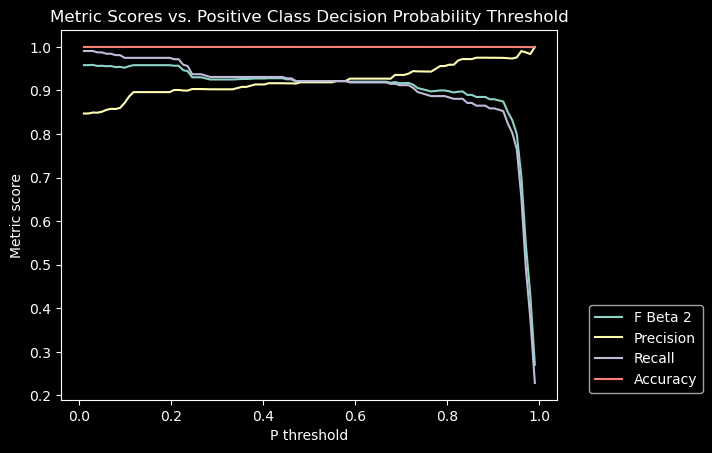

In [23]:
# threshold : Le seul de probabilité par défaut dans la régression logistique est à 0,5
# Le but est ici de connaître les meilleurs seuils pour 
# le fbeta_score, precision_score, recall_score, accuracy_score

thresh_ps = np.linspace(0.01,0.99,101)
# Renvoie des nombres régulièrement espacés sur un intervalle spécifié 0.01 à 0.99
# pour 101 échantillons à gérer

model_val_probs = lr.predict_proba(X_val_scaled)[:,1] 
# Prédiction sur les classes positives

fbeta_scores, prec_scores, rec_scores, acc_scores = [], [], [], []

for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    fbeta_scores.append(fbeta_score(y_val, model_val_labels, beta=2))
    # Enregistrer dans fbeta_score, les score_f2 suivant les seuils définies : thresh_ps
    prec_scores.append(precision_score(y_val, model_val_labels))
    # Enregistrer dans prec_score, les prec_score suivant les seuils définies : thresh_ps
    rec_scores.append(recall_score(y_val, model_val_labels))
    # Enregistrer dans rec_score, les rec_score suivant les seuils définies : thresh_ps
    acc_scores.append(accuracy_score(y_val, model_val_labels))
    # Enregistrer dans accuracy_score, les accuracy_score suivant les seuils définies : thresh_ps
    
# Afficher les courbes : #
plt.plot(thresh_ps, fbeta_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
# Le titre du graphique 

plt.legend(['F Beta 2','Precision','Recall','Accuracy'], 
           # Coordonnées et placement de la bbox
           bbox_to_anchor = (1.05, 0), 
           loc = 'lower left')
            
# 
plt.xlabel('P threshold')
# Le label en x
plt.ylabel('Metric score')
# Le label en y

# Calcul les meilleurs score et les meilleurs seuils : #

best_fbeta_score = np.max(fbeta_scores) 
best_thresh_p_fbeta = thresh_ps[np.argmax(fbeta_scores)]
best_recall_score = np.max(rec_scores)
best_thresh_p_rec = thresh_ps[np.argmax(rec_scores)]
best_prec_score = np.max(prec_scores)
best_thresh_p_prec = thresh_ps[np.argmax(prec_scores)]

# Afficher les scores des meilleurs seuils : #

print('Logistic Regression Model best F Beta2 score %.3f at prob decision threshold >= %.3f' 
      % (best_fbeta_score, best_thresh_p_fbeta))
print('Logistic Regression Model best recall score %.3f at prob decision threshold >= %.3f' 
      % (best_recall_score, best_thresh_p_rec))
print('Logistic Regression Model best precision score %.3f at prob decision threshold >= %.3f' 
      % (best_recall_score, best_thresh_p_prec))

### Weighted Logistic Regression

In [24]:
# Test avec la régression logistique pondérée
# Cette dernière est utilisée lorsque l'ensemble de données est déséquilibré

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, 
    y, 
    test_size = .2, 
    stratify = y, 
    random_state = 2)

In [25]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, 
    y_train_val, 
    test_size = .25, 
    stratify = y_train_val, 
    random_state = 2)

In [26]:
X_train_scaled = pd.DataFrame(
    std.fit_transform(X_train),
    columns = X_train.columns)

In [27]:
lr2 = LogisticRegression(
    solver = 'lbfgs', 
    max_iter = 1000000, 
    n_jobs = -1, 
    class_weight = 'balanced')

# class_weight = 'balanced' : poids équilibrés
# cette option utilise les valeurs de y pour ajuster automatiquement les pondérations inversement proportionnelles 
# aux fréquences de classe dans les données d'entrée

In [28]:
with joblib.parallel_backend("dask"):
    lr2.fit(
        X_train_scaled, 
        y_train)

In [29]:
X_val_scaled = pd.DataFrame(
    std.transform(X_val), 
    columns = X_val.columns)

In [30]:
y_val_preds = lr2.predict(X_val_scaled)

print("Precision: {}, Recall: {}, F2 Score: {}".format(
    precision_score(y_val, y_val_preds), 
    recall_score(y_val, y_val_preds), 
    fbeta_score(y_val, y_val_preds, beta=2.0)))

Precision: 0.8315789473684211, Recall: 0.9905956112852664, F2 Score: 0.9541062801932366


In [31]:
lr2_confusion = confusion_matrix(
    y_val, 
    y_val_preds)

In [32]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in lr2_confusion.flatten()]
group_percentages = ["{0:0.4%}".format(value) for value in lr2_confusion.flatten()/np.sum(lr2_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

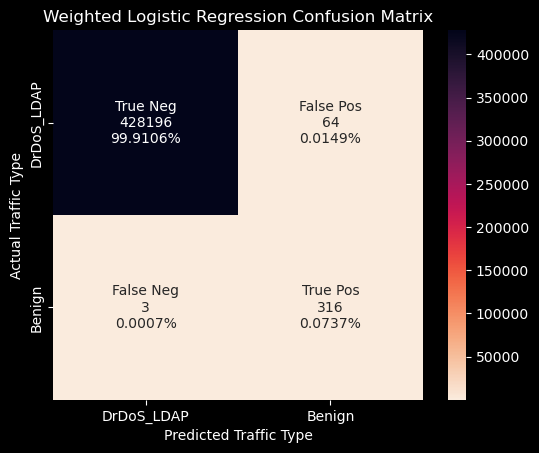

In [33]:
sns.heatmap(lr2_confusion, 
            cmap = 'rocket_r', 
            annot = labels, fmt = '', 
            square = True, 
            xticklabels = ['DrDoS_LDAP', 'Benign'], 
            yticklabels = ['DrDoS_LDAP', 'Benign'])

plt.xlabel('Predicted Traffic Type')
plt.ylabel('Actual Traffic Type')
plt.title('Weighted Logistic Regression Confusion Matrix');

Balanced Logistic Regression Model best F Beta2 score 0.965 at prob decision threshold >= 0.990
Balanced Logistic Regression Model best recall score 0.991 at prob decision threshold >= 0.010
Balanced Logistic Regression Model best precision score 0.991 at prob decision threshold >= 0.990


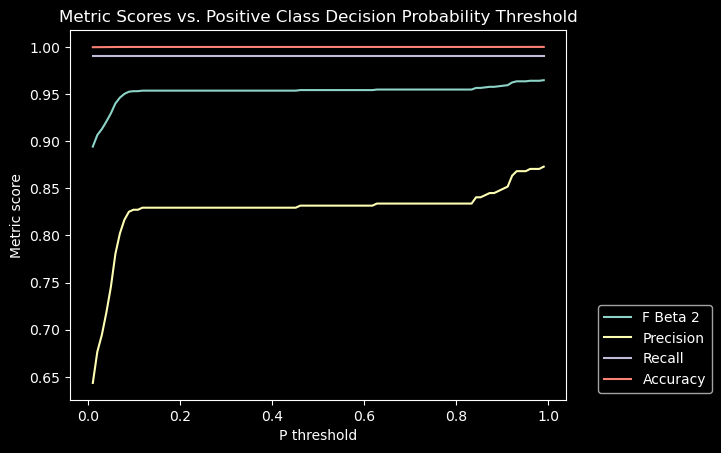

In [34]:
thresh_ps = np.linspace(0.01,0.99,101)
model_val_probs = lr2.predict_proba(X_val_scaled)[:,1] # positive class probs, same basic logistic model we fit in section 2 

fbeta_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    fbeta_scores.append(fbeta_score(y_val, model_val_labels, beta=2))    
    prec_scores.append(precision_score(y_val, model_val_labels))
    rec_scores.append(recall_score(y_val, model_val_labels))
    acc_scores.append(accuracy_score(y_val, model_val_labels))
    
plt.plot(thresh_ps, fbeta_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F Beta 2','Precision','Recall','Accuracy'], bbox_to_anchor=(1.05, 0), loc='lower left')
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_fbeta_score = np.max(fbeta_scores) 
best_thresh_p_fbeta = thresh_ps[np.argmax(fbeta_scores)]
best_recall_score = np.max(rec_scores)
best_thresh_p_rec = thresh_ps[np.argmax(rec_scores)]
best_prec_score = np.max(prec_scores)
best_thresh_p_prec = thresh_ps[np.argmax(prec_scores)]

print('Balanced Logistic Regression Model best F Beta2 score %.3f at prob decision threshold >= %.3f' 
      % (best_fbeta_score, best_thresh_p_fbeta))
print('Balanced Logistic Regression Model best recall score %.3f at prob decision threshold >= %.3f' 
      % (best_recall_score, best_thresh_p_rec))
print('Balanced Logistic Regression Model best precision score %.3f at prob decision threshold >= %.3f' 
      % (best_recall_score, best_thresh_p_prec))

### Random Forest

In [35]:
# Random forest
# Cet algorithme construit une multitudes d'arbres de décision 
# sur différent échantillons. Dans le cas d'une classification,
# La sortie de la forêt aléatoire est la classe sélectionnée 
# par la plupart des arbres

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators = 1000, 
    n_jobs = -1, 
    random_state = 3)

In [36]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, 
    y, 
    test_size = .2, 
    stratify = y, 
    random_state = 3)

In [37]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, 
    y_train_val, 
    test_size = .25, 
    stratify = y_train_val, 
    random_state = 3)

In [38]:
with joblib.parallel_backend("dask"):
    rf.fit(X_train, y_train)

In [39]:
y_val_preds = rf.predict(X_val)
print("Precision: {}, Recall: {}, F2 Score: {}".format(
    precision_score(y_val, y_val_preds), 
    recall_score(y_val, y_val_preds), 
    fbeta_score(y_val, y_val_preds, beta=2.0)))

Precision: 0.9905956112852664, Recall: 0.9905956112852664, F2 Score: 0.9905956112852664


In [40]:
rf_confusion = confusion_matrix(
    y_val, 
    y_val_preds)

In [41]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in rf_confusion.flatten()]
group_percentages = ["{0:0.4%}".format(value) for value in rf_confusion.flatten()/np.sum(rf_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

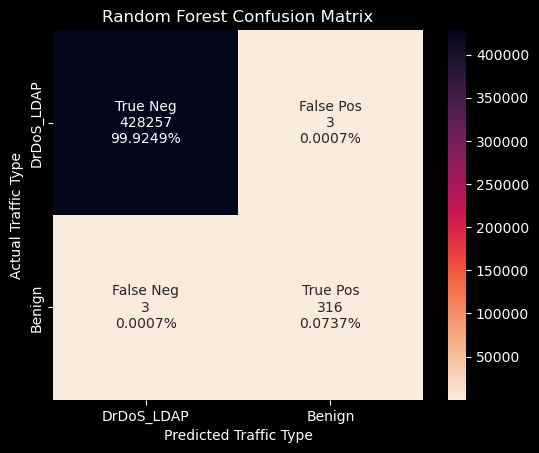

In [42]:
sns.heatmap(rf_confusion,
            cmap = 'rocket_r', 
            annot = labels, 
            fmt = '', 
            square = True, 
            xticklabels = ['DrDoS_LDAP', 'Benign'], 
            yticklabels = ['DrDoS_LDAP', 'Benign'])

plt.xlabel('Predicted Traffic Type')
plt.ylabel('Actual Traffic Type')
plt.title('Random Forest Confusion Matrix');

### Weighted Random Forest

In [43]:
rf2 = RandomForestClassifier(
    n_estimators = 1000, 
    n_jobs = -1, 
    random_state = 4, 
    class_weight = 'balanced')

In [44]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, 
    y, 
    test_size = .2, 
    stratify = y, 
    random_state = 4)

In [45]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, 
    y_train_val, 
    test_size = .25, 
    stratify = y_train_val, 
    random_state = 4)

In [46]:
with joblib.parallel_backend("dask"):
    rf2.fit(
        X_train, 
        y_train)

In [47]:
y_val_preds = rf2.predict(X_val)
print("Precision: {}, Recall: {}, F2 Score: {}".format(
    precision_score(y_val, y_val_preds), 
    recall_score(y_val, y_val_preds), 
    fbeta_score(y_val, y_val_preds, beta = 2.0)))

Precision: 0.9904458598726115, Recall: 0.9749216300940439, F2 Score: 0.9779874213836476


In [48]:
rf2_confusion = confusion_matrix(
    y_val, 
    y_val_preds)

In [49]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in rf2_confusion.flatten()]
group_percentages = ["{0:0.4%}".format(value) for value in rf2_confusion.flatten()/np.sum(rf2_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

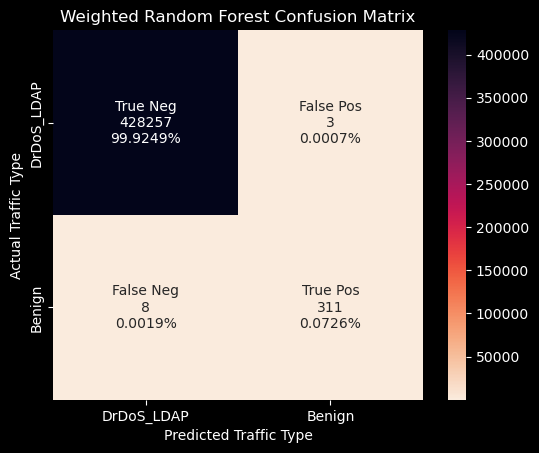

In [50]:
sns.heatmap(
    rf2_confusion,
    cmap = 'rocket_r', 
    annot = labels, 
    fmt = '', 
    square = True, 
    xticklabels = ['DrDoS_LDAP', 'Benign'], 
    yticklabels = ['DrDoS_LDAP', 'Benign'])

plt.xlabel('Predicted Traffic Type')
plt.ylabel('Actual Traffic Type')
plt.title('Weighted Random Forest Confusion Matrix');

### Random Forest with Bootstrap Class Weighting

In [51]:
# Source : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

# Le mode "balanced_subsample" est le même que "balanced" 
# sauf que les poids sont calculés sur la base de l'échantillon bootstrap pour chaque arbre cultivé.

rf3 = RandomForestClassifier(
    n_estimators = 1000, 
    n_jobs = -1, 
    random_state = 5, 
    class_weight = 'balanced_subsample')

In [52]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, 
    y, 
    test_size = .2, 
    stratify = y, 
    random_state = 5)

In [53]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, 
    y_train_val, 
    test_size = .25, 
    stratify = y_train_val, 
    random_state = 5)

In [54]:
with joblib.parallel_backend("dask"):
    rf3.fit(
        X_train, 
        y_train)

In [55]:
y_val_preds = rf3.predict(X_val)
print("Precision: {}, Recall: {}, F2 Score: {}".format(
    precision_score(y_val, y_val_preds), 
    recall_score(y_val, y_val_preds), 
    fbeta_score(y_val, y_val_preds, beta=2.0)))

Precision: 0.9874213836477987, Recall: 0.9843260188087775, F2 Score: 0.9849435382685069


In [56]:
rf3_confusion = confusion_matrix(
    y_val, 
    y_val_preds)

In [57]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in rf3_confusion.flatten()]
group_percentages = ["{0:0.4%}".format(value) for value in rf3_confusion.flatten()/np.sum(rf3_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

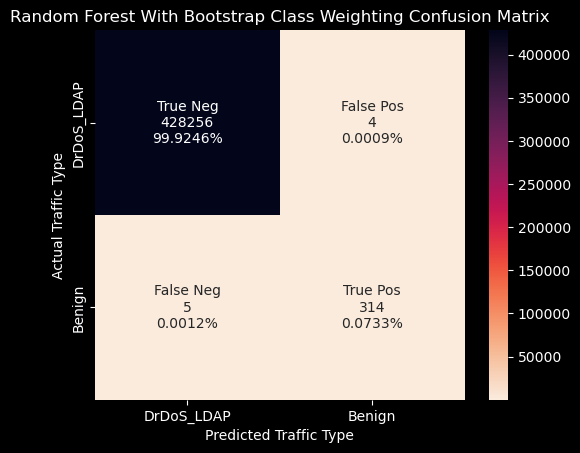

In [58]:
sns.heatmap(
    rf3_confusion,
    cmap = 'rocket_r', 
    annot = labels, 
    fmt = '', 
    square = True, 
    xticklabels = ['DrDoS_LDAP', 'Benign'], 
    yticklabels = ['DrDoS_LDAP', 'Benign'])

plt.xlabel('Predicted Traffic Type')
plt.ylabel('Actual Traffic Type')
plt.title('Random Forest With Bootstrap Class Weighting Confusion Matrix');

### Random forest with Data Resampling

In [59]:
# Source : https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html
    
# Une forêt aléatoire équilibrée sous-échantillonne au hasard chaque échantillon boostrap pour l'équilibrer

from imblearn.ensemble import BalancedRandomForestClassifier

imb_rf = BalancedRandomForestClassifier(
    n_estimators = 1000, 
    random_state = 6, 
    n_jobs = -1)

In [60]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, 
    y, 
    test_size = .2, 
    stratify = y, 
    random_state = 6)

In [61]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, 
    y_train_val, 
    test_size = .25, 
    stratify = y_train_val, 
    random_state = 6)

In [62]:
with joblib.parallel_backend("dask"):
    imb_rf.fit(
        X_train, 
        y_train)

In [63]:
y_val_preds = imb_rf.predict(X_val)
print("Precision: {}, Recall: {}, F2 Score: {}".format(
    precision_score(y_val, y_val_preds), 
    recall_score(y_val, y_val_preds), 
    fbeta_score(y_val, y_val_preds, beta=2.0)))

Precision: 0.5186991869918699, Recall: 1.0, F2 Score: 0.8434690639873083


In [64]:
imb_rf_confusion = confusion_matrix(
    y_val, 
    y_val_preds)

In [65]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in imb_rf_confusion.flatten()]
group_percentages = ["{0:0.4%}".format(value) for value in imb_rf_confusion.flatten()/np.sum(imb_rf_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

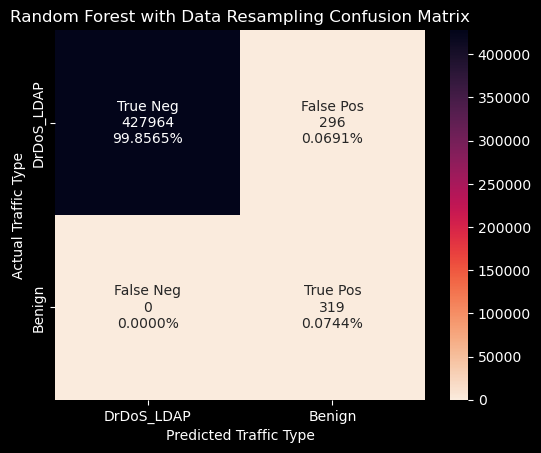

In [66]:
sns.heatmap(imb_rf_confusion,
            cmap = 'rocket_r', 
            annot = labels, fmt = '', 
            square = True, 
            xticklabels = ['DrDoS_LDAP', 'Benign'], 
            yticklabels = ['DrDoS_LDAP', 'Benign'])

plt.xlabel('Predicted Traffic Type')
plt.ylabel('Actual Traffic Type')
plt.title('Random Forest with Data Resampling Confusion Matrix');

### Random Forest with Data Resampling (Balanced Class Weight)

In [67]:
# Une forêt aléatoire équilibrée sous-échantillonne au hasard chaque échantillon boostrap pour l'équilibrer
# Le mode "Balanced" utilise les valeurs de y pour ajuster automatiquement les poids inversement proportionnels aux fréquences de classe dans les données d'entrée

imb_rf2 = BalancedRandomForestClassifier(
    n_estimators = 1000, 
    random_state = 7, 
    class_weight = 'balanced', 
    n_jobs = -1)

In [68]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, 
    y, 
    test_size = .2, 
    stratify = y, 
    random_state = 7)

In [69]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, 
    y_train_val, 
    test_size = .25, 
    stratify = y_train_val, 
    random_state = 7)

In [70]:
with joblib.parallel_backend("dask"):
    imb_rf2.fit(
        X_train, 
        y_train)

In [71]:
y_val_preds = imb_rf2.predict(X_val)
print("Precision: {}, Recall: {}, F2 Score: {}".format(
    precision_score(y_val, y_val_preds), 
    recall_score(y_val, y_val_preds), 
    fbeta_score(y_val, y_val_preds, beta=2.0)))

Precision: 0.5462328767123288, Recall: 1.0, F2 Score: 0.8575268817204301


In [72]:
imb_rf2_confusion = confusion_matrix(
    y_val, 
    y_val_preds)

In [73]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in imb_rf2_confusion.flatten()]
group_percentages = ["{0:0.4%}".format(value) for value in imb_rf2_confusion.flatten()/np.sum(imb_rf2_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

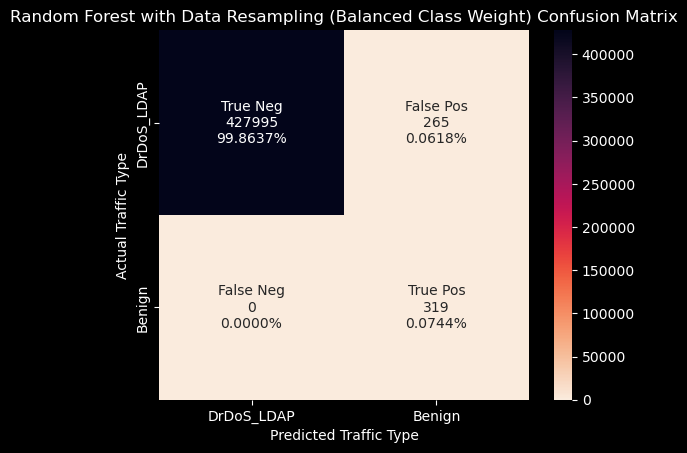

In [74]:
sns.heatmap(
    imb_rf2_confusion,
    cmap = 'rocket_r', 
    annot = labels, 
    fmt = '', 
    square = True, 
    xticklabels = ['DrDoS_LDAP', 'Benign'], 
    yticklabels = ['DrDoS_LDAP', 'Benign'])

plt.xlabel('Predicted Traffic Type')
plt.ylabel('Actual Traffic Type')
plt.title('Random Forest with Data Resampling (Balanced Class Weight) Confusion Matrix');

### Random Forest with Data Resampling (Bootstrap Class Weighting)

In [75]:
# Le mode "balanced_subsample" est le même que "balanced" sauf que les poids sont calculés 
# sur la base de l'échantillon bootstrap pour chaque arbre cultivé.

imb_rf3 = BalancedRandomForestClassifier(
    n_estimators = 1000, 
    random_state = 8, 
    class_weight = 'balanced_subsample', 
    n_jobs = -1)

In [76]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    y, 
    test_size = .2, 
    stratify = y, 
    random_state = 8)

In [77]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, 
    y_train_val, 
    test_size = .25, 
    stratify = y_train_val, 
    random_state = 8)

In [78]:
with joblib.parallel_backend("dask"):
    imb_rf3.fit(
        X_train, 
        y_train)

In [79]:
y_val_preds = imb_rf3.predict(X_val)
print("Precision: {}, Recall: {}, F2 Score: {}".format(
    precision_score(y_val, y_val_preds), 
    recall_score(y_val, y_val_preds), 
    fbeta_score(y_val, y_val_preds, beta = 2.0)))

Precision: 0.5747747747747748, Recall: 1.0, F2 Score: 0.8711086837793555


In [80]:
imb_rf3_confusion = confusion_matrix(
    y_val, 
    y_val_preds)

In [81]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in imb_rf3_confusion.flatten()]
group_percentages = ["{0:0.4%}".format(value) for value in imb_rf3_confusion.flatten()/np.sum(imb_rf3_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

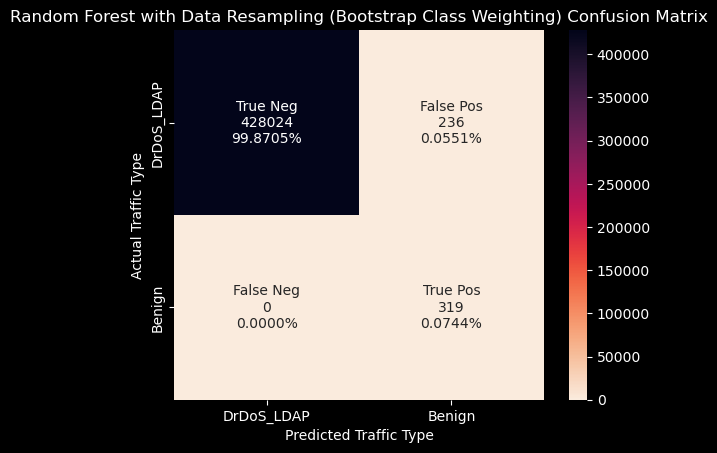

In [82]:
sns.heatmap(imb_rf3_confusion,
            cmap = 'rocket_r', 
            annot = labels, 
            fmt = '', 
            square = True, 
            xticklabels = ['DrDoS_LDAP', 'Benign'], 
            yticklabels = ['DrDoS_LDAP', 'Benign'])

plt.xlabel('Predicted Traffic Type')
plt.ylabel('Actual Traffic Type')
plt.title('Random Forest with Data Resampling (Bootstrap Class Weighting) Confusion Matrix');

### XGBoost

In [83]:
# Source : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

# Cet algorithme construit un modèle additif de manière progressive; il permet l'optimisation de fonctions
# de perte différentiables arbitraires. A chaque étape n_classes_, les arbres de régression sont ajustés 
# sur le gradient négatif de la fonction de perte, par exemple la perte logarithmique binaire ou multiclasse. 
# La classification binaire est un cas particulier où un seul arbre de régression est induit.

import xgboost as xgb

gbm = xgb.XGBClassifier(
                        n_estimators = 100000,
                        # Le nombre d'arbres
                        max_depth = 6,
                        # La profondeur maximale de l'arbre
                        objective = "binary:logistic",
                        # 
                        learning_rate = .1,
                        # Le taux d'apprentissage
                        subsample = 1,
                        # Flotteur de sous-échantillon, valeur = 1 par défaut si il est < 1 
                        # cela entraîne une augmentation du gradient stochastique
                        scale_pos_weight = 99,
                        # Le rapport du nombre de classes néagatives par rapport à la classe positive
                        min_child_weight = 1,
                        # Somme minimale de poids d'instance pour un enfant par défaut : 1
                        colsample_bytree = 1,
                        # Le rapport de sous-échantillon des colonnes pour chaque niveau
                        tree_method = 'hist',
                        # choix de l'algorithme utilisée : 
                        # hist : Algorithme glouton approximatif optimisé pour l'histogramme plus rapide.
                        use_label_encoder = False,
                        # utiliser un label spécifique
                        )

In [84]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, 
    y, 
    test_size = .2, 
    stratify = y, 
    random_state = 9)

In [85]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, 
    y_train_val, 
    test_size = .25, 
    stratify = y_train_val, 
    random_state = 9)

In [86]:
early_stopping_rounds = 20

eval_set = [(X_train,y_train),(X_val,y_val)] 

fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set = eval_set,
                    eval_metric = 'auc',
                    early_stopping_rounds = early_stopping_rounds,
                    verbose = True 
                   )

/Users/patrice/miniforge3/envs/xgboost/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/patrice/miniforge3/envs/xgboost/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.99996	validation_1-auc:0.99996
[1]	validation_0-auc:0.99996	validation_1-auc:0.99996
[2]	validation_0-auc:0.99999	validation_1-auc:0.99999
[3]	validation_0-auc:0.99999	validation_1-auc:0.99999
[4]	validation_0-auc:0.99999	validation_1-auc:0.99685
[5]	validation_0-auc:0.99999	validation_1-auc:0.99685
[6]	validation_0-auc:0.99999	validation_1-auc:0.99685
[7]	validation_0-auc:0.99999	validation_1-auc:0.99685
[8]	validation_0-auc:0.99999	validation_1-auc:0.99685
[9]	validation_0-auc:0.99999	validation_1-auc:0.99685
[10]	validation_0-auc:0.99999	validation_1-auc:0.99685
[11]	validation_0-auc:0.99999	validation_1-auc:0.99685
[12]	validation_0-auc:0.99999	validation_1-auc:0.99685
[13]	validation_0-auc:0.99999	validation_1-auc:0.99685
[14]	validation_0-auc:0.99999	validation_1-auc:0.99685
[15]	validation_0-auc:0.99999	validation_1-auc:0.99685
[16]	validation_0-auc:0.99999	validation_1-auc:0.99685
[17]	validation_0-auc:0.99999	validation_1-auc:0.99685
[18]	validation_0-au

In [87]:
y_val_preds = gbm.predict(X_val)
print("Precision: {}, Recall: {}, F2 Score: {}".format(
    precision_score(y_val, y_val_preds), 
    recall_score(y_val, y_val_preds), 
    fbeta_score(y_val, y_val_preds, beta=2.0)))

Precision: 0.8932584269662921, Recall: 0.9968652037617555, F2 Score: 0.9742647058823531


In [88]:
gbm_confusion = confusion_matrix(
    y_val, 
    y_val_preds)

In [89]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in gbm_confusion.flatten()]
group_percentages = ["{0:0.4%}".format(value) for value in gbm_confusion.flatten()/np.sum(gbm_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

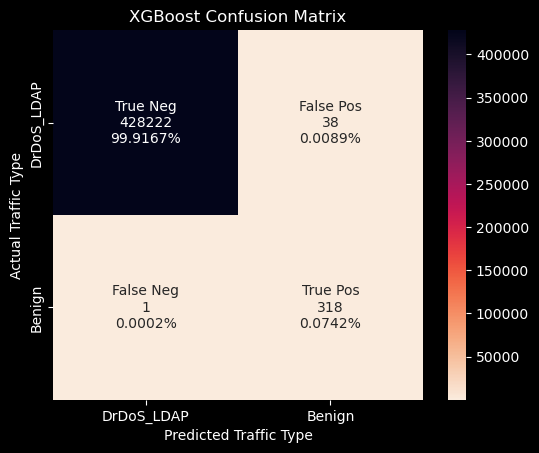

In [90]:
sns.heatmap(gbm_confusion,
            cmap = 'rocket_r', 
            annot = labels, 
            fmt = '', 
            square = True, 
            xticklabels = ['DrDoS_LDAP', 'Benign'], 
            yticklabels = ['DrDoS_LDAP', 'Benign'])

plt.xlabel('Predicted Traffic Type')
plt.ylabel('Actual Traffic Type')
plt.title('XGBoost Confusion Matrix');

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

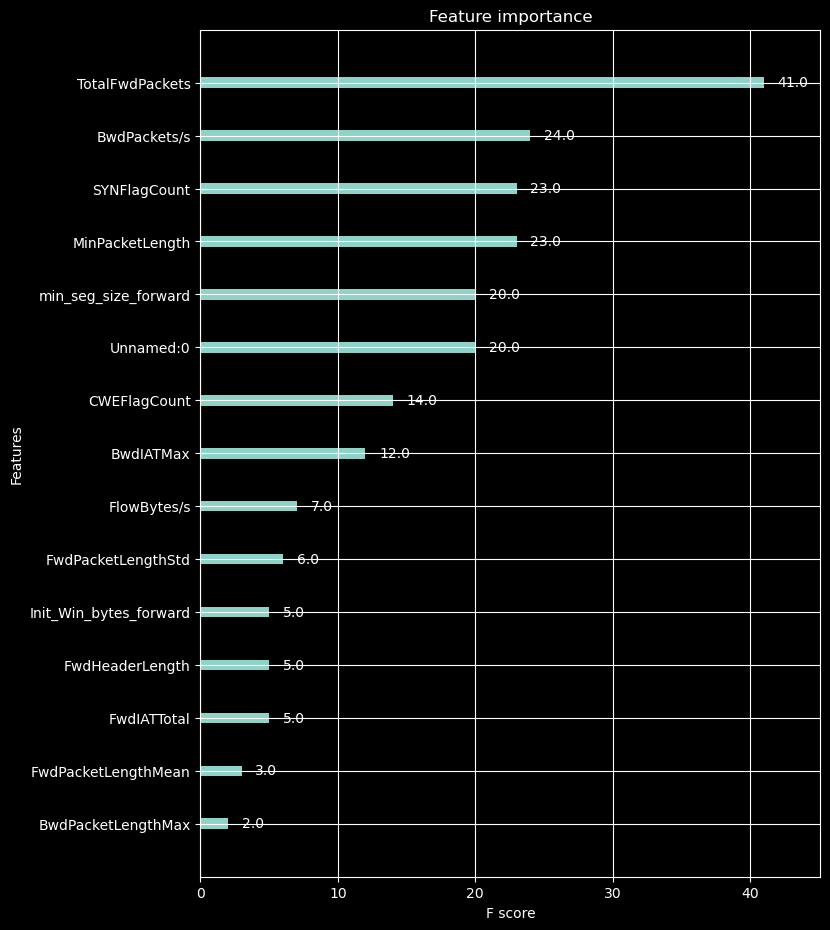

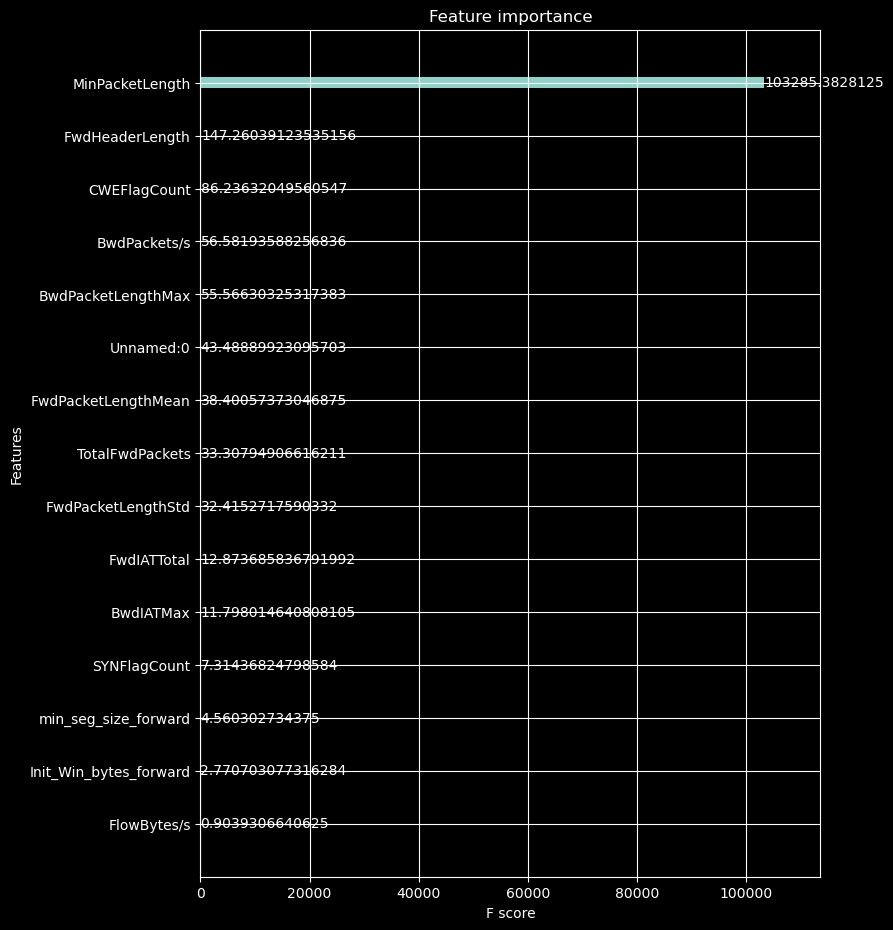

In [91]:
# Afficher les caractéristiques les plus importantes par rapport au gain

fig, ax = plt.subplots(figsize = (8,11))
xgb.plot_importance(gbm, ax = ax)
fig,ax2 = plt.subplots(figsize = (8,11))
xgb.plot_importance(gbm, importance_type = 'gain', ax = ax2)



In [92]:
gbm.get_booster().get_score(importance_type = 'weight')

{'Unnamed:0': 20.0,
 'TotalFwdPackets': 41.0,
 'FwdPacketLengthMean': 3.0,
 'FwdPacketLengthStd': 6.0,
 'BwdPacketLengthMax': 2.0,
 'FlowBytes/s': 7.0,
 'FwdIATTotal': 5.0,
 'BwdIATMax': 12.0,
 'FwdHeaderLength': 5.0,
 'BwdPackets/s': 24.0,
 'MinPacketLength': 23.0,
 'SYNFlagCount': 23.0,
 'CWEFlagCount': 14.0,
 'Init_Win_bytes_forward': 5.0,
 'min_seg_size_forward': 20.0}

In [93]:
gbm.get_booster().get_score(importance_type='gain')

{'Unnamed:0': 43.48889923095703,
 'TotalFwdPackets': 33.30794906616211,
 'FwdPacketLengthMean': 38.40057373046875,
 'FwdPacketLengthStd': 32.4152717590332,
 'BwdPacketLengthMax': 55.56630325317383,
 'FlowBytes/s': 0.9039306640625,
 'FwdIATTotal': 12.873685836791992,
 'BwdIATMax': 11.798014640808105,
 'FwdHeaderLength': 147.26039123535156,
 'BwdPackets/s': 56.58193588256836,
 'MinPacketLength': 103285.3828125,
 'SYNFlagCount': 7.31436824798584,
 'CWEFlagCount': 86.23632049560547,
 'Init_Win_bytes_forward': 2.770703077316284,
 'min_seg_size_forward': 4.560302734375}

In [94]:
gbm.best_ntree_limit

3

### XGBoost 2 

In [95]:
gbm2 = xgb.XGBClassifier(
                        n_estimators = 100000,
                        max_depth = 9,
                        objective = "binary:logistic",
                        learning_rate = .001,
                        subsample = .5,
                        scale_pos_weight = 99,
                        min_child_weight = 1,
                        colsample_bytree = 1,
                        tree_method = 'hist',
                        use_label_encoder = False,
                        )

In [96]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, 
    y, 
    test_size = .2, 
    stratify = y, 
    random_state = 10)

In [97]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, 
    y_train_val, 
    test_size = .25, 
    stratify = y_train_val, 
    random_state = 10)

In [98]:
eval_set = [(X_train,y_train),(X_val,y_val)] 
fit_model = gbm2.fit( 
                    X_train, y_train, 
                    eval_set = eval_set,
                    eval_metric = 'auc',
                    early_stopping_rounds = 20,
                    verbose = True 
                   )

/Users/patrice/miniforge3/envs/xgboost/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/patrice/miniforge3/envs/xgboost/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.99944	validation_1-auc:0.99996
[1]	validation_0-auc:0.99997	validation_1-auc:0.99997
[2]	validation_0-auc:0.99997	validation_1-auc:0.99997
[3]	validation_0-auc:0.99997	validation_1-auc:0.99997
[4]	validation_0-auc:0.99997	validation_1-auc:0.99997
[5]	validation_0-auc:0.99997	validation_1-auc:0.99997
[6]	validation_0-auc:0.99997	validation_1-auc:0.99997
[7]	validation_0-auc:0.99997	validation_1-auc:0.99997
[8]	validation_0-auc:0.99997	validation_1-auc:0.99997
[9]	validation_0-auc:0.99997	validation_1-auc:0.99997
[10]	validation_0-auc:0.99997	validation_1-auc:0.99997
[11]	validation_0-auc:0.99997	validation_1-auc:0.99997
[12]	validation_0-auc:0.99997	validation_1-auc:0.99997
[13]	validation_0-auc:0.99997	validation_1-auc:0.99997
[14]	validation_0-auc:0.99997	validation_1-auc:0.99997
[15]	validation_0-auc:0.99997	validation_1-auc:0.99997
[16]	validation_0-auc:0.99997	validation_1-auc:0.99997
[17]	validation_0-auc:0.99997	validation_1-auc:0.99997
[18]	validation_0-au

In [99]:
gbm2.best_ntree_limit

4

In [100]:
y_val_preds = gbm2.predict(X_val, iteration_range=(1,24))
print("Precision: {}, Recall: {}, F2 Score: {}".format(
    precision_score(y_val, y_val_preds), 
    recall_score(y_val, y_val_preds), 
    fbeta_score(y_val, y_val_preds, beta = 2.0)))

Precision: 0.9077809798270894, Recall: 0.987460815047022, F2 Score: 0.9704251386321627


In [101]:
gbm2_confusion = confusion_matrix(
    y_val, 
    y_val_preds)

In [102]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in gbm2_confusion.flatten()]
group_percentages = ["{0:0.4%}".format(value) for value in gbm2_confusion.flatten()/np.sum(gbm2_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

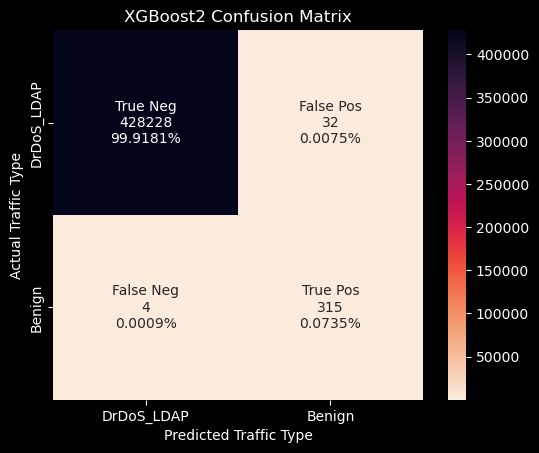

In [103]:
sns.heatmap(gbm2_confusion,
            cmap = 'rocket_r', 
            annot = labels, 
            fmt = '', 
            square = True, 
            xticklabels = ['DrDoS_LDAP', 'Benign'], 
            yticklabels = ['DrDoS_LDAP', 'Benign'])

plt.xlabel('Predicted Traffic Type')
plt.ylabel('Actual Traffic Type')
plt.title('XGBoost2 Confusion Matrix');